We will write the workflow in Snakefile for run manually of coding steps to automake and parallelize a simple multi-step analysis. This will help to ensure reproducilibility, transparency, integrity, and scalability in this project work.

The workflow includes:
- IS 477 Data Cleaning.ipny
- IS 477 Data Analysis.ipny

In [50]:
%%writefile Snakefile
# 1.Final result we want
rule run_all:
    input:
        "analysis_shed1.PNG",
        "analysis_shed 2.PNG",
        "analysis_shed 3.PNG",
        "analysis_shed 4.PNG",
        "analysis_shed 5.PNG",
        "analysis_shed 6.PNG",
        "analysis_shed 7.PNG",
        "analysis_shed 8.PNG",
        "analysis_shed 9.PNG",
        "analysis_cfpb.PNG",
        "merged.csv",
        "analysis_merged 1.PNG",
        "analysis_merged 2.PNG"

# 2. Clean SHED 2020/2024 (from SAS to one cleaned CSV)
rule clean_shed:
    input:
        shed2024 = "shed2024.sas7bdat",
        shed2020 = "public2020.sas7bdat"
    output:
        shed20 = "shed20_cleaned2.csv",
        shed24 = "shed24_cleaned2.csv"
    shell:
        """
        python scripts/clean_shed.py \
            --shed2024 {input.shed2024} \
            --shed2020 {input.shed2020} \
            --out20 {output.shed20} \
            --out24 {output.shed24}
        """

# 3. Clean CFPB credit data
rule clean_cfpb:
    input:
        "volume_data_Score_Level_CRC (4).csv"
    output:
        "cfpd_cleaned2.csv"
    shell:
        """
        python scripts/clean_cfpb.py \
            --infile {input} \
            --out {output}
        """


# 4. match the sample size shed24 comparing with shed20
rule shed24_match_shed20:
    input:
       shed24 = "shed24_cleaned2.csv",

    output:
        "df_shed24ver1.csv"
    shell:
        """
        python scripts/shed24_match_shed20.py \
            --shed24 {input.shed24} \
            --out {output}
        """



# 5. concat shed20 and shed24ver1
rule aggregate_sheds:
    input:
        shed24 = "df_shed24ver1.csv",
        shed20 = "shed20_cleaned2.csv"
    output:
        "df_shed.csv"
    shell:
        """
        python scripts/aggregate_sheds.py \
            --shed24 {input.shed24} \
            --shed20 {input.shed20} \
            --out {output}
        """

# 6. shed analysis
rule shed_analysis:
    input:
        shed = "df_shed.csv",

    output:
        "analysis_shed1.PNG",
        "analysis_shed 2.PNG",
        "analysis_shed 3.PNG",
        "analysis_shed 4.PNG",
        "analysis_shed 5.PNG",
        "analysis_shed 6.PNG",
        "analysis_shed 7.PNG",
        "analysis_shed 8.PNG",
        "analysis_shed 9.PNG"
    shell:
        """
        python scripts/shed_analysis.py \
            --shed {input.shed}

        """

#7. take out the people who don't own credit card
rule shed_credit:
    input:
        shed24 = "df_shed24ver1.csv",
        shed20 = "shed20_cleaned2.csv"
    output:
        shed20_cc = "shed20ver2.csv",
        shed24_cc = "shed24ver3.csv"
    shell:
        """
        python scripts/shed_credit.py \
            --shed24 {input.shed24} \
            --shed20 {input.shed20} \
            --out20 {output.shed20_cc} \
            --out24 {output.shed24_cc}
        """

#8. concat sheds dataset who only has credit card
rule shed_credit_concat:
    input:
        shed24 = "shed24ver3.csv",
        shed20 = "shed20ver2.csv"
    output:
        "shed2.csv"

    shell:
        """
        python scripts/shed_credit_concat.py \
            --shed24 {input.shed24} \
            --shed20 {input.shed20} \
            --out {output}
        """

#9. group shed dataset on score group and year
rule shed_group:
    input:
        shed = "shed2.csv",

    output:
        "shed_year.csv"

    shell:
        """
        python scripts/shed_group.py \
            --shed {input.shed} \

            --out {output}
        """

#10. extract the year 2020 and 2024 of CFPB dataset
rule cfpb_group:
    input:
        cfpb = "cfpd_cleaned2.csv",

    output:
        "crc_year.csv"

    shell:
        """
        python scripts/cfpb_group.py \
            --cfpb {input.cfpb} \

            --out {output}
        """

#11. cfpb analysis
rule cfpb_analysis:
    input:
        cfpb = "crc_year.csv",

    output:
        "analysis_cfpb.PNG"

    shell:
        """
        python scripts/cfpb_analysis.py \
            --cfpb {input.cfpb} \

            --out {output}
        """

#12. merge cpfb and shed data
rule merge:
    input:
        cfpb = "crc_year.csv",
        shed = "shed_year.csv"

    output:
        "merged.csv"

    shell:
        """
        python scripts/merge.py \
            --cfpb {input.cfpb} \
            --shed {input.shed} \
            --out {output}
        """

#13. merge data analysis
rule merge_analysis:
    input:
        merged = "merged.csv",

    output:
        "analysis_merged 2.PNG",
        "analysis_merged 1.PNG"

    shell:
        """
        python scripts/merge_analysis.py \
            --merged {input.merged} \
            --out1 "{output[0]}"\
            --out2 "{output[1]}"\
        """

Overwriting Snakefile


Now let's install the snakemake in your Python.

In [44]:
pip install snakemake

Now let's run the snakemake workflow engine wi 1 CPU core at a time.

In [51]:
!snakemake --cores 1

Assuming unrestricted shared filesystem usage.
host: 81ea42587cc5
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                    count
-------------------  -------
aggregate_sheds            1
clean_shed                 1
merge                      1
merge_analysis             1
run_all                    1
shed24_match_shed20        1
shed_analysis              1
shed_credit                1
shed_credit_concat         1
shed_group                 1
total                     10

Select jobs to execute...
Execute 1 jobs...

[Wed Dec 10 04:07:57 2025]
localrule clean_shed:
    input: shed2024.sas7bdat, public2020.sas7bdat
    output: shed20_cleaned2.csv, shed24_cleaned2.csv
    jobid: 4
    reason: Missing output files: shed24_cleaned2.csv, shed20_cleaned2.csv; Updated input files: shed2024.sas7bdat, public2020.sas7bdat
    resources: tmpdir=/tmp
python3: can't ope

We can check the workflow of status check below.

In [52]:
! snakemake --summary

Building DAG of jobs...
output_file	date	rule	log-file(s)	status	plan
analysis_shed1.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 2.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 3.PNG	-	shed_analysis	-	missing	update pending
analysis_shed 4.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 5.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 6.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 7.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 8.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
analysis_shed 9.PNG	Wed Dec 10 02:54:01 2025	shed_analysis	-	ok	update pending
df_shed.csv	Wed Dec 10 02:42:48 2025	aggregate_sheds	-	ok	update pending
df_shed24ver1.csv	Wed Dec 10 02:41:49 2025	shed24_match_shed20	-	ok	update pending
shed20_cleaned2.csv	-	clean_shed		missing	update pending
shed24_cleaned2.csv	-	cle

# Visualization Workflow

Install Graphviz for import the image of workflow diagram.

In [53]:
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Now let's draw the workflow picture using our snakemake text.

In [54]:
!snakemake --dag | dot -Tpng > dag.png

Building DAG of jobs...


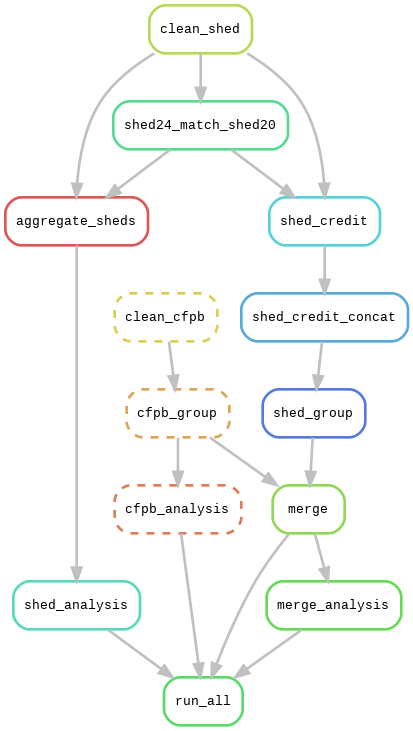

In [55]:


from IPython.display import Image
Image(filename="dag.png")